# **FDS - Final Project: Classification of Fake and Real Faces**

## **ResNet-50 Fine-Tuning with Adam Optimizer**

In this notebook we fine-tune ResNet-50 to the 140k fake and real faces dataset. We use hyperparameter tuning to try different combinations of loss function, learning rate and regularization, then compare the results.

#### **Performance Evaluation and Explainability**

* Accuracy, Precision, Recall, F1-Scores
* Confusion Matrix
* Grad-CAM
* ROC curve and AUC score
* Precision-Recall curve


#### Import libraries

In [ ]:
pip install grad-cam

In [ ]:
!pip install torchcam

In [42]:
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchvision import transforms, models
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchvision.transforms.functional import to_pil_image
import seaborn as sns
import cv2
from google.colab import drive
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
import copy
from collections import defaultdict

Mount Google Drive for saving results later.

In [4]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

Mounted at /content/drive


Set random seeds for reproducibility of results.

In [77]:
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Import and read dataset

In [6]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [02:51<00:00, 21.2MB/s]
100% 3.75G/3.75G [02:51<00:00, 23.4MB/s]


In [7]:
!unzip 140k-real-and-fake-faces.zip -d /content/

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: /content/real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflatin

In [8]:
train_df = pd.read_csv('/content/train.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)
valid_df = pd.read_csv('/content/valid.csv', index_col=0)
print('Train Dataset Paths and Labels')
display(train_df.head())
print('Test Dataset Paths and Labels')
display(test_df.head())
print('Validation Dataset Paths and Labels')
display(valid_df.head())

Train Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  31355      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  02884      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  33988      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  53875      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  24149      1      real   

                   path  
0  train/real/31355.jpg  
1  train/real/02884.jpg  
2  train/real/33988.jpg  
3  train/real/53875.jpg  
4  train/real/24149.jpg

Test Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  18233      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  54317      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  40155      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  12875      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  52543      1      real   

                  path  
0  test/real/18233.jpg  
1  test/real/54317.jpg  
2  test/real/40155.jpg  
3  test/real/12875.jpg  
4  test/real/52543.jpg

Validation Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  20001      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  11264      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  19817      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  46851      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  10411      1      real   

                   path  
0  valid/real/20001.jpg  
1  valid/real/11264.jpg  
2  valid/real/19817.jpg  
3  valid/real/46851.jpg  
4  valid/real/10411.jpg

Adjust paths in the `path` columns

In [9]:
# Base directory where images are stored
base_img_dir = '/content/real_vs_fake/real-vs-fake/'

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

#### Visualize some images

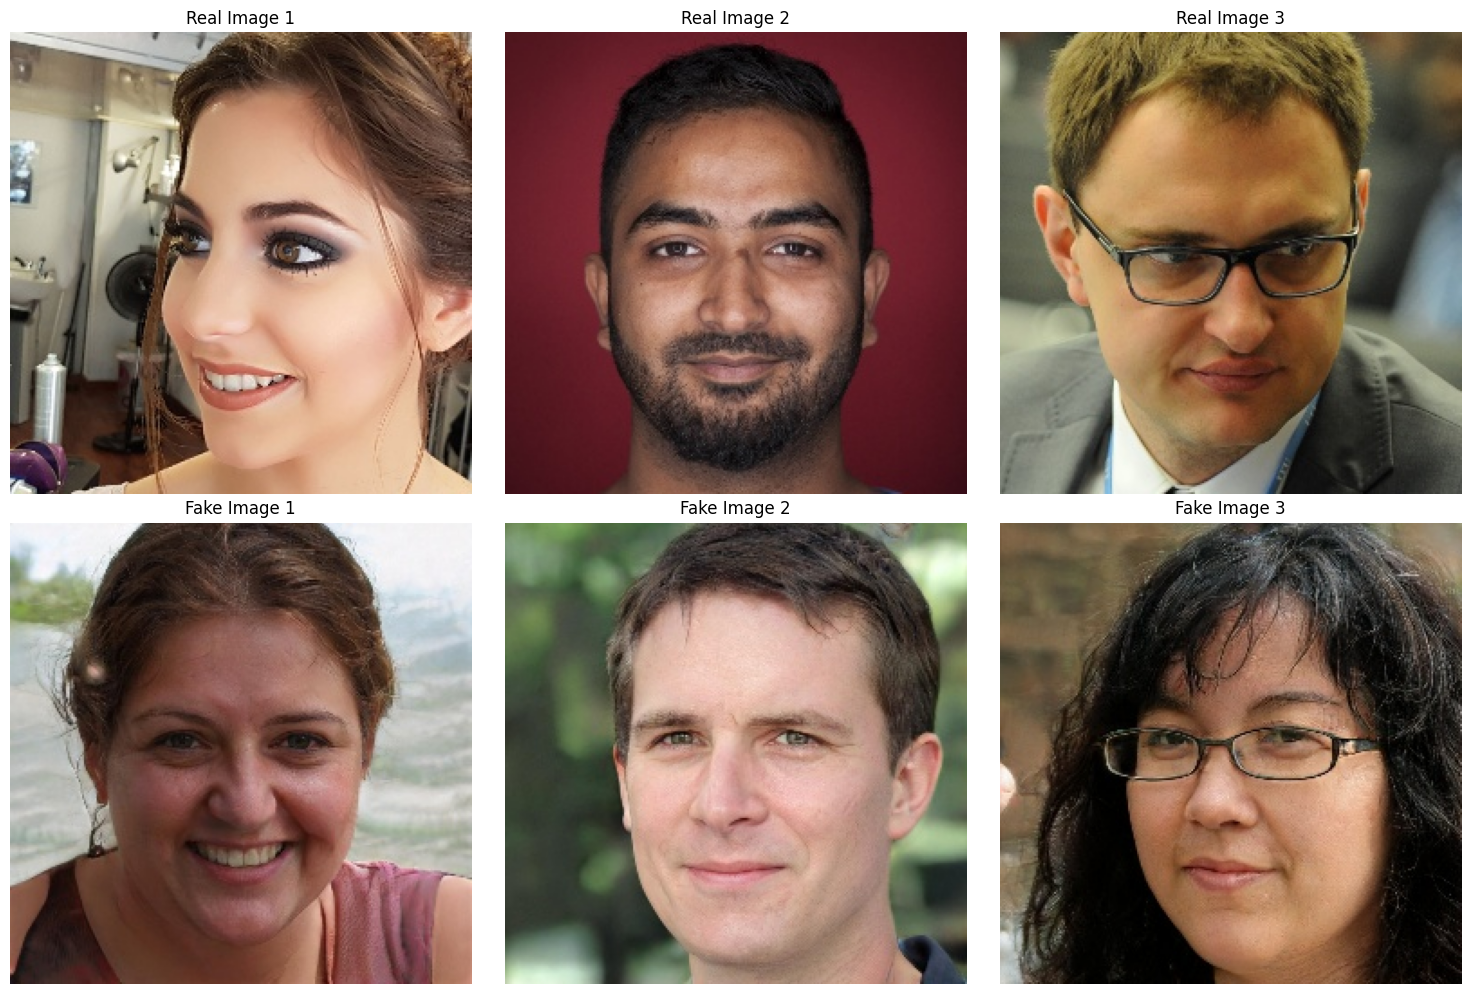

In [33]:
# Pick 3 real and 3 fake images to show
real_imgs_to_show = random.sample(list(train_df[train_df.label == 1].image_path), 3)
fake_imgs_to_show = random.sample(list(train_df[train_df.label == 0].image_path), 3)

# Open images using PIL
real_images = [Image.open(path) for path in real_imgs_to_show]
fake_images = [Image.open(path) for path in fake_imgs_to_show]

# Display images side by side using Matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Add real images in the first row
for ax, img, title in zip(axes[0], real_images, ["Real Image 1", "Real Image 2", "Real Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

# Add fake images in the second row
for ax, img, title in zip(axes[1], fake_images, ["Fake Image 1", "Fake Image 2", "Fake Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Create FaceDataset class
We create a FaceDataset class that can be passed to a DataLoader, which will take care of batching and shuffling.

In [11]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        '''
        self.dataframe = dataframe  # Store the dataframe
        self.transform = transform  # Store the transform (if present)

    def __len__(self):
        return len(self.dataframe)  # Return the length of the dataframe

    def __getitem__(self, idx):
        # Get the image path and label from the dataframe
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)  # Label is 0 or 1 (fake or real)

        # Open the image using PIL
        image = Image.open(img_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label

## Fine-Tuning ResNet-50 to the Dataset

#### Load ResNet50

We will use the pre-trained CNN ResNet-50 and fine-tune it to the 140k-real-and-fake-faces dataset, then compare its accuracy to that of other models. We get the ResNet-50 weights by setting the weights parameter of the model to `ResNet50_Weights.DEFAULT`. ResNet-50 expects images that are pre-processed with specific transformations specified at https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50 (reference can also be found here: https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198). There are two transformation recipes for pre-processing the data to pass into the ResNet-50 CNN; we choose the more recent recipe.

In [20]:
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights

# Load pre-trained ResNet50
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the final fully connected layer for binary classification
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2)  # Output logits for 2 classes

# Define transformations to preprocess the images
resnet50_transform = transforms.Compose([
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),  # Resize the image to size [232]
    transforms.CenterCrop(224),  # Crop the image to size [224]
    transforms.ToTensor(),  # Convert the image to tensor and scale values to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using resnet50 mean and std parameters
])

In [21]:
# Create Dataset instances for train, validation, and test sets
train_dataset = FaceDataset(dataframe=train_df, transform=resnet50_transform)
valid_dataset = FaceDataset(dataframe=valid_df, transform=resnet50_transform)
test_dataset = FaceDataset(dataframe=test_df, transform=resnet50_transform)

# Create DataLoader instances for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Set device to cuda if it is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move model to the right device
resnet50.to(device)

We first try the model using `CrossEntropyLoss`, which is the loss function generally used for multiclass classification, and applies softmax to get a distribution over the classes. Then we try with `BCEWithLogitsLoss`, which uses the sigmoid for binary classification. In both cases, we will use the Adam optimizer, and try with the learning rates 0.001 and 0.01. Finally, we try regularization with weight decay.

To keep the notebook clean, we keep a separate python module that runs experiments based on the input hyper-parameters and saves result data and images on google drive.

In [62]:
def experiment(train_loader, valid_loader, test_loader, model, loss_function, optimizer, num_epochs, lr, weight_decay=0, momentum=0):
    '''
    Function that performs training, validation and testing on a model, given a loss function, optimizer, and hyper-parameters.
    The function returns the results of training the model
    Args:
    - train_loader (DataLoader): DataLoader for training set
    - valid_loader (DataLoader): DataLoader for validation set
    - test_loader (DataLoader): DataLoader for test set
    - model (nn.Module): Model to train
    - loss_function (nn.Module): Loss function to use
    - optimizer (torch.optim): Optimizer to use
    - lr (float): Learning rate for optimizer
    - weight_decay (float): Weight decay for optimizer
    - momentum (float): Momentum for optimizer
    - num_epochs (int): Number of epochs to train for
    Returns:
    - model (nn.Module): Trained model
    - results (dict): Dictionary containing training and validation loss and accuracy for each epoch + other results
    '''
    # Set device to cuda if it is available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Move model to the right device
    model.to(device)

    # Define Loss function
    if loss_function == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
    elif loss_function == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

    # Define optimizer function
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer
    elif optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum) # SGD optimizer

    # Initialize lists for accuracies, losses, Grad-CAM images, probabilities of predicting class 1
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    true_labels = []
    pred_labels = []
    probs = []

    num_epochs = num_epochs

    # Iterate over the epochs
    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set the model to training mode
        train_running_loss = 0.0
        correct, total = 0, 0
        prob = []

        # Iterate over the batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            # Set parameter gradients to zero
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            if loss_function == 'BCEWithLogitsLoss':
                # convert labels to float and ensure single-channel output
                loss = criterion(outputs[:, 1], labels.float())
            elif loss_function == 'CrossEntropyLoss':
                loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Optimization
            optimizer.step()

            # Increase training loss
            train_running_loss += loss.item()

            # Calculate accuracy
            predicted = torch.max(outputs, 1)[1]  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss for the training epoch
        avg_train_loss = train_running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}: Training Loss = {avg_train_loss:.4f}, Training Accuracy = {train_accuracy:.4f}')

        # Validation Phase
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_correct, val_total = 0, 0

        # Initialize label lists for this epoch
        epoch_true_labels = []
        epoch_pred_labels = []

        # Iterate over the batches in valid_loader
        for val_inputs, val_labels in valid_loader:
            # Move to device
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Forward pass
            val_outputs = model(val_inputs)

            with torch.no_grad():  # no need to compute gradients here

                # Compute loss
                if loss_function == 'BCEWithLogitsLoss':
                    # convert labels to float and ensure single-channel output
                    val_loss = criterion(val_outputs[:, 1], val_labels.float())
                elif loss_function == 'CrossEntropyLoss':
                    val_loss = criterion(val_outputs, val_labels)

                # Increase validation loss
                val_running_loss += val_loss.item()

                # Calculate accuracy
                val_predicted = torch.max(val_outputs, 1)[1]  # Get predicted class
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

                # Memorize true and predicted labels for explainability
                epoch_true_labels.extend(val_labels.cpu().numpy())
                epoch_pred_labels.extend(val_predicted.cpu().numpy())

            # Calculate probabilities for prediction = class 1 (real) using softmax
            prob.extend(torch.softmax(val_outputs, dim=1)[:, 1].cpu().detach().numpy())

        # Calculate average loss for the validation epoch
        avg_val_loss = val_running_loss / len(valid_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy
        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)

        # Append results to the probs, true_labels, pred_labels lists
        probs.append(prob)
        true_labels.append(epoch_true_labels)
        pred_labels.append(epoch_pred_labels)

        print(f'Epoch {epoch+1}: Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}')

    print('Finished Training')

    # confusion matrix
    conf_matrix = confusion_matrix(true_labels[-1], pred_labels[-1])

    # Get predictions on the test set
    model.eval()

    with torch.no_grad(): # no need to compute gradients here

        test_predictions = []
        test_true_labels = []

        # Iterate over the batches in test_loader
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # move to device
            outputs = model(images) # compute output
            _, predicted = torch.max(outputs, 1) # get prediction
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(test_true_labels, test_predictions)
    precision = precision_score(test_true_labels, test_predictions, average='binary')
    recall = recall_score(test_true_labels, test_predictions, average='binary')
    f1 = f1_score(test_true_labels, test_predictions, average='binary')
    roc_auc = roc_auc_score(test_true_labels, test_predictions)

    # Print the results
    print('\nTest Results')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Test ROC AUC: {roc_auc:.4f}')

    # Test Confusion Matrix
    test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)

    report = classification_report(true_labels[-1], pred_labels[-1], target_names=['Fake', 'Real'])
    print("\nClassification Report:\n", report)

    # Put results in a dictionary
    results = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'true_labels': true_labels,
        'pred_labels': pred_labels,
        'probs': probs,
        'test_true_labels': test_true_labels,
        'test_predictions': test_predictions,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix,
        'test_conf_matrix': test_conf_matrix
      }

    return model, results

In [48]:
def get_grad_cam_images(model, transform, target_layer, real_images, fake_images, path):
    '''
    Function that takes a trained model and returns Grad-CAM results for a selection of real and fake image paths
    Args:
    - model (nn.Module): Trained model
    - transform (torchvision.transforms): Image transformations
    - target_layer (nn.Module): Target layer for Grad-CAM
    - real_images (list): List of real image paths
    - fake_images (list): List of fake image paths
    - path (str): Path to save Grad-CAM images
    Returns:
    - None
    '''
    # Set the model to evaluation mode
    model.eval()

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Function to process an image and generate Grad-CAM heatmap
    def generate_gradcam_overlay(img_path, target_class):
        # Load and preprocess the image
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Convert the image to a NumPy array for visualization
        img_for_visualization = np.array(image.resize((224, 224))) / 255.0  # Scale to [0, 1]

        # Generate Grad-CAM heatmap
        grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_class)])
        heatmap = grayscale_cam[0, :]  # Extract the heatmap

        # Overlay heatmap on the image
        superimposed_img = show_cam_on_image(img_for_visualization, heatmap, use_rgb=True)

        # Get model prediction
        with torch.no_grad():
            output = model(img_tensor)
            pred_class = output.argmax(dim=1).item()

        return superimposed_img, pred_class

    # Create subplots
    fig, axes = plt.subplots(2, len(real_images), figsize=(15, 10))

    # First row: Real images
    for i, img_path in enumerate(real_images):
        target_class = 1  # Actual label for real images
        superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
        axes[0, i].imshow(superimposed_img)
        axes[0, i].set_title(f"Real Image {i+1}\nPred: {pred_class}, Actual: {target_class}")
        axes[0, i].axis("off")

    # Second row: Fake images
    for i, img_path in enumerate(fake_images):
        target_class = 0  # Actual label for fake images
        superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
        axes[1, i].imshow(superimposed_img)
        axes[1, i].set_title(f"Fake Image {i+1}\nPred: {pred_class}, Actual: {target_class}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.savefig(path)
    plt.show()

In [54]:
def plot_figures(results, paths, num_epochs):
    '''
    Function that, given training, validation and test results, plots and saves images
    Args:
    - results (dict): Dictionary containing training, validation and test results
    Returns:
    - None
    '''

    train_losses = results['train_losses']
    val_losses = results['val_losses']
    train_accuracies = results['train_accuracies']
    val_accuracies = results['val_accuracies']
    true_labels = results['true_labels']
    pred_labels = results['pred_labels']
    probs = results['probs']
    conf_matrix = results['conf_matrix']
    test_conf_matrix = results['test_conf_matrix']

    plt.figure(figsize=(15, 16))

    # Training and validation loss curves
    plt.subplot(3, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Trainining Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(paths[0])

    # Training and validation accuracy curves
    plt.subplot(3, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(paths[1])

    # ROC curve
    fpr, tpr, _ = roc_curve(true_labels[-1], probs[-1])

    plt.subplot(3, 2, 3)
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.savefig(paths[2])

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels[-1], probs[-1])

    plt.subplot(3, 2, 4)
    plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.savefig(paths[3])

    # Confusion Matrix Validation

    # Plot the confusion matrix
    plt.subplot(3,2,5)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.title('Validation Confusion Matrix (last epoch)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(paths[4])

    # Confusion Matrix Testing
    plt.subplot(3,2,6)
    sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(paths[5])
    plt.show()

### Cross Entropy Loss + Adam Optimizer + learning rate = 0.01

In [ ]:
# Create a copy of resnet50
resnet50_CE_Adam_01 = copy.deepcopy(resnet50)
resnet50_CE_Adam_01, results_CE_Adam_01 = experiment(train_loader, valid_loader, test_loader, resnet50_CE_Adam_01, loss = 'CrossEntropyLoss', optimizer = 'Adam', num_epochs = 5, lr = 0.01)

In [ ]:
target_layer = resnet50_CE_Adam_01.layer4[-1]
get_grad_cam_images(resnet50_CE_Adam_01, resnet50_transform, target_layer, real_imgs_to_show, fake_imgs_to_show, '/content/grad_cam_CE_Adam_01.png')

In [ ]:
CE_Adam_01_paths = ['/content/CE_Adam_01_loss.png', '/content/CE_Adam_01_acc.png', '/content/CE_Adam_01_ROC.png', '/content/CE_Adam_01_PR', '/content/CE_Adam_01_conf_val.png', '/content/CE_Adam_01_conf_test.png']
plot_figures(results_CE_Adam_01, CE_Adam_01_paths, 5)

### BCE With Logits Loss + Adam Optimizer + learning rate 0.001

In [63]:
# Create a copy of resnet50
resnet50_BCE_Adam_001 = copy.deepcopy(resnet50)
resnet50_BCE_Adam_001, results_BCE_Adam_001 = experiment(train_loader, valid_loader, test_loader, resnet50_BCE_Adam_001, loss_function = 'BCEWithLogitsLoss', optimizer = 'Adam', num_epochs = 5, lr = 0.001)

Epoch 1: Training Loss = 0.0821, Training Accuracy = 0.9677
Epoch 1: Validation Loss = 0.1194, Validation Accuracy = 0.9599
Epoch 2: Training Loss = 0.0335, Training Accuracy = 0.9874
Epoch 2: Validation Loss = 0.0658, Validation Accuracy = 0.9783
Epoch 3: Training Loss = 0.0252, Training Accuracy = 0.9910
Epoch 3: Validation Loss = 0.1593, Validation Accuracy = 0.9407
Epoch 4: Training Loss = 0.0214, Training Accuracy = 0.9920
Epoch 4: Validation Loss = 0.0220, Validation Accuracy = 0.9919
Epoch 5: Training Loss = 0.0173, Training Accuracy = 0.9940
Epoch 5: Validation Loss = 0.0479, Validation Accuracy = 0.9836
Finished Training

Test Results
Test Accuracy: 0.9831
Test Precision: 0.9682
Test Recall: 0.9990
Test F1 Score: 0.9834
Test ROC AUC: 0.9831

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      0.97      0.98     10000
        Real       0.97      1.00      0.98     10000

    accuracy                           0.98     200

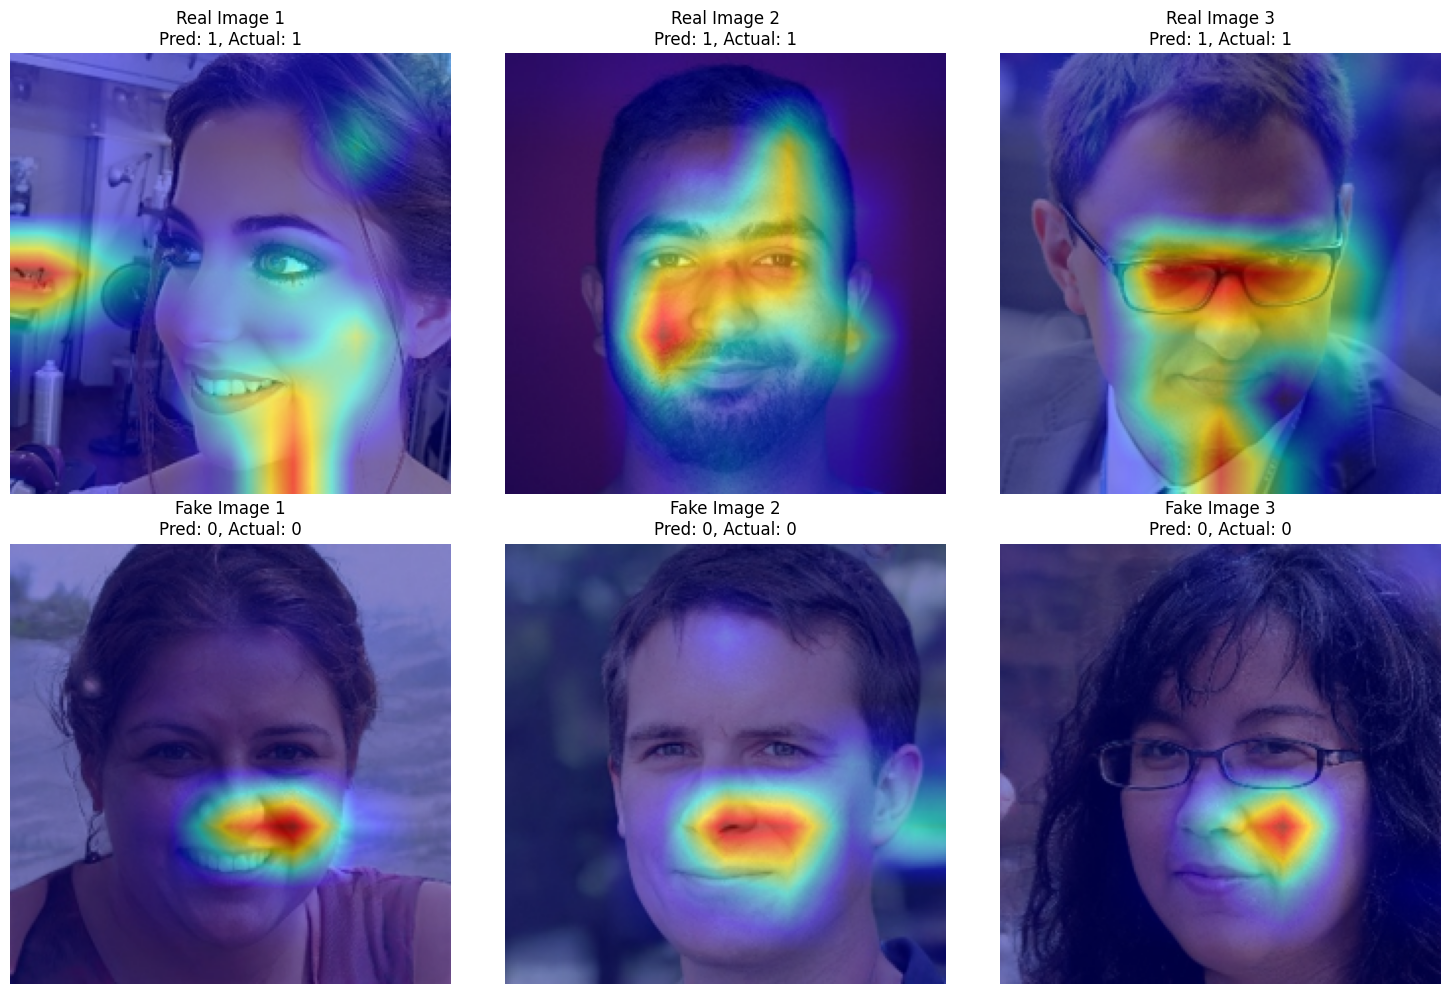

In [80]:
target_layer = resnet50_BCE_Adam_001.layer4[-1]
get_grad_cam_images(resnet50_BCE_Adam_001, resnet50_transform, target_layer, real_imgs_to_show, fake_imgs_to_show, '/content/grad_cam_BCE_Adam_001.png')

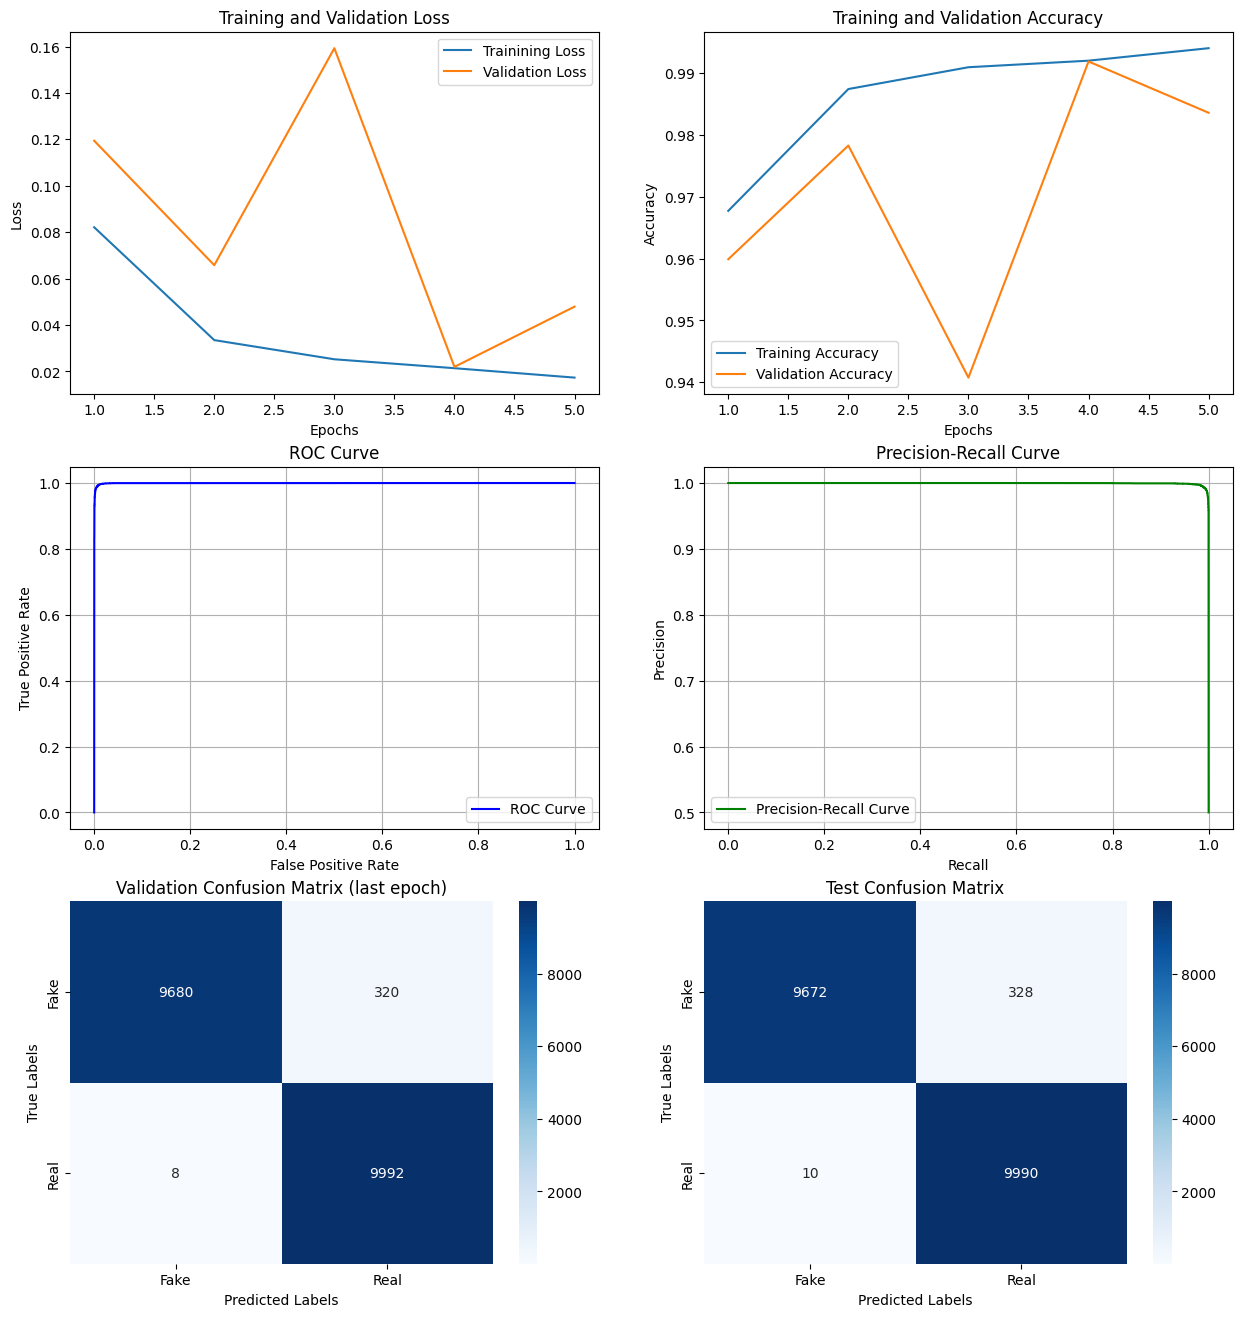

In [67]:
BCE_Adam_001_paths = ['/content/BCE_Adam_001_loss.png', '/content/BCE_Adam_001_acc.png', '/content/BCE_Adam_001_ROC.png', '/content/BCE_Adam_001_PR', '/content/BCE_Adam_001_conf_val.png', '/content/BCE_Adam_001_conf_test.png']
plot_figures(results_BCE_Adam_001, BCE_Adam_001_paths, 5)